In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util
from bmi_dynamics_code import analyze_lqr

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


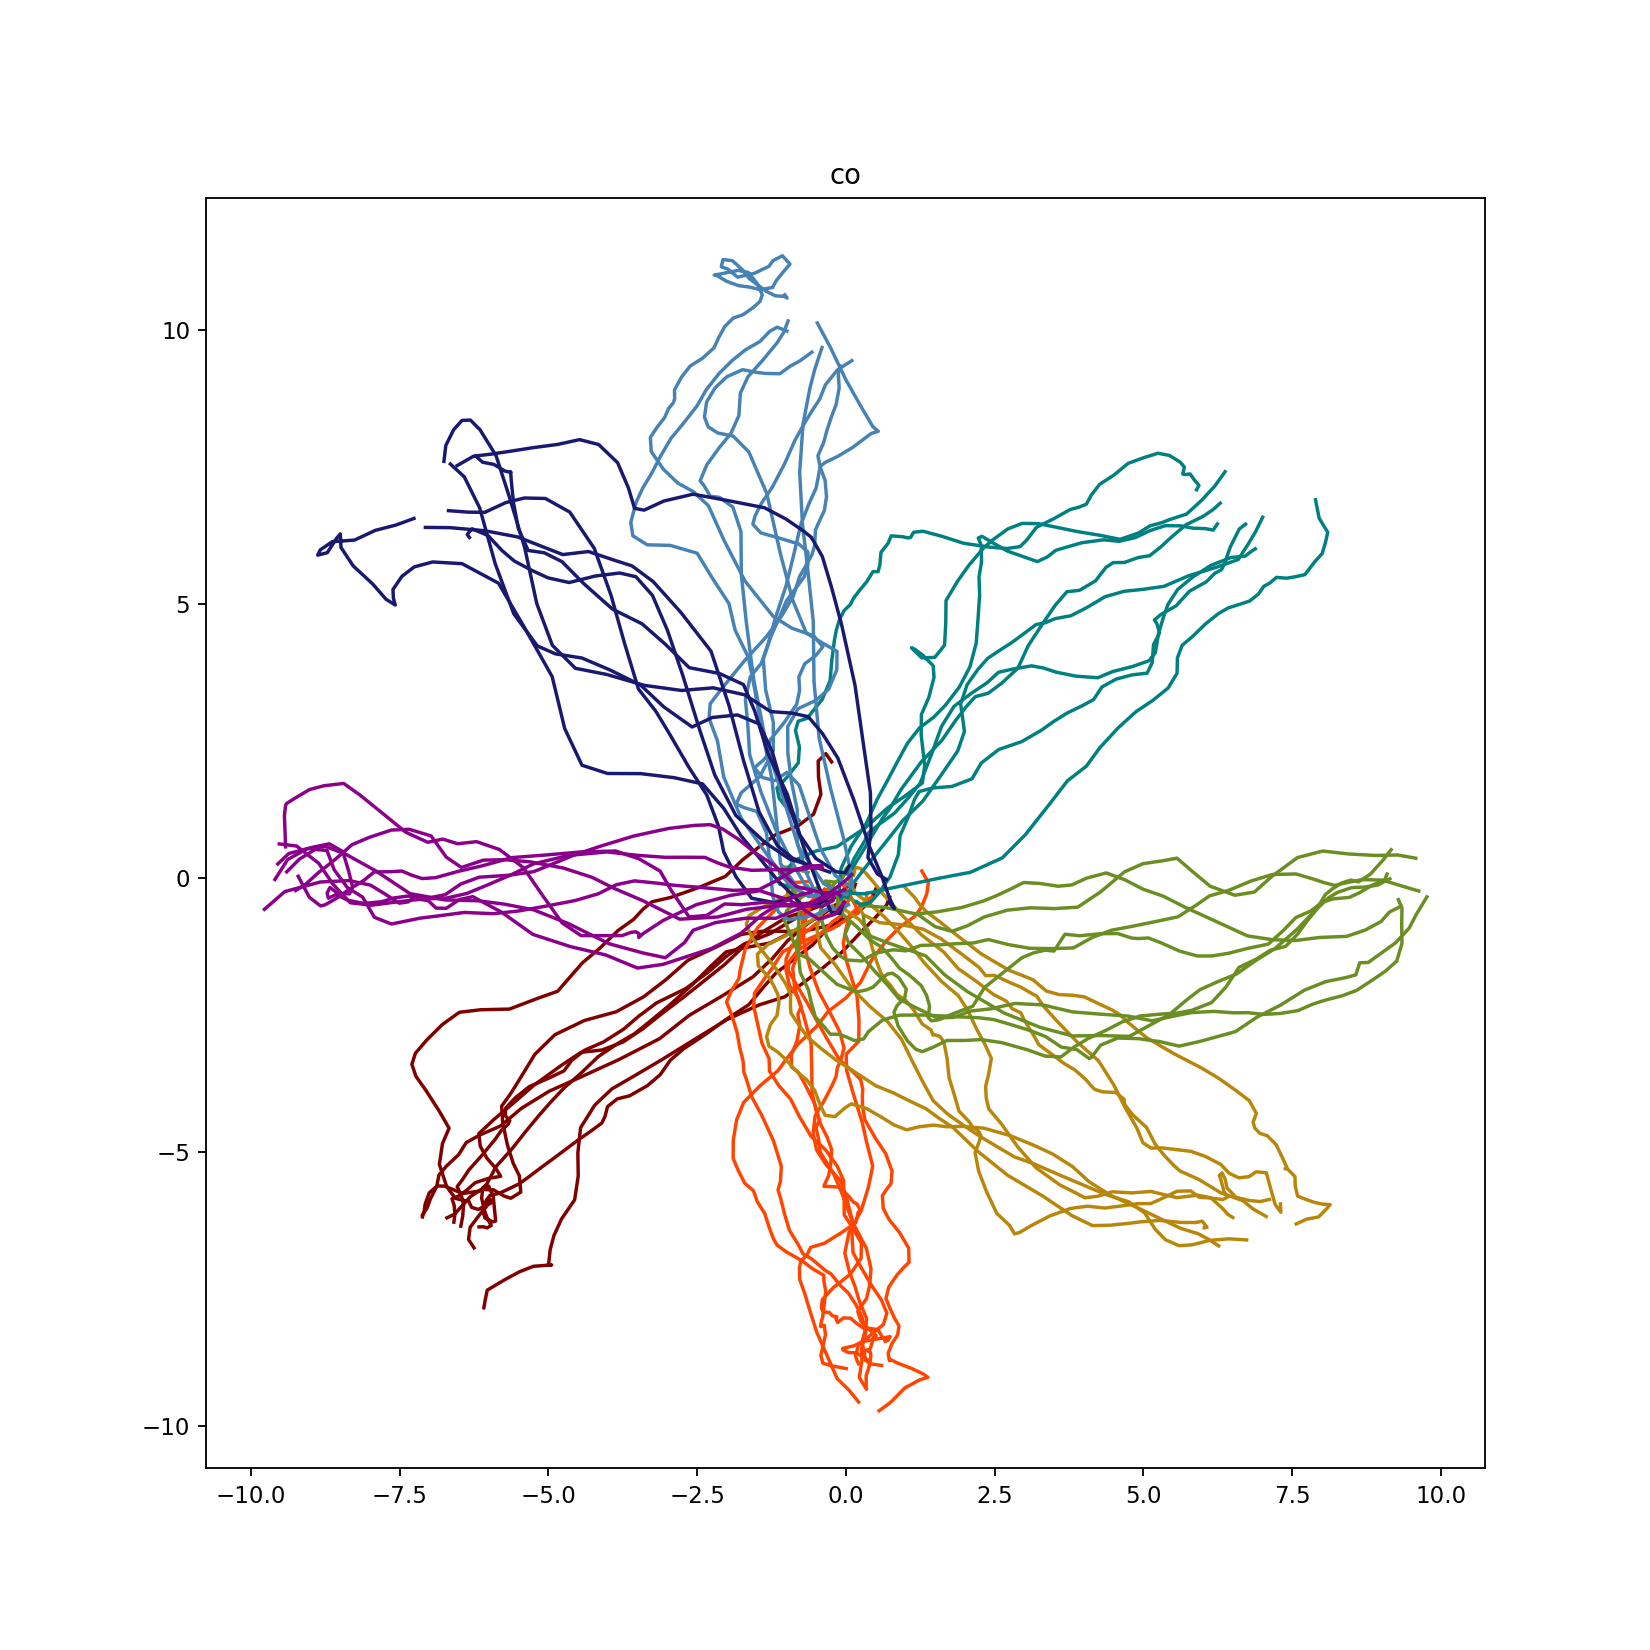

<IPython.core.display.Javascript object>


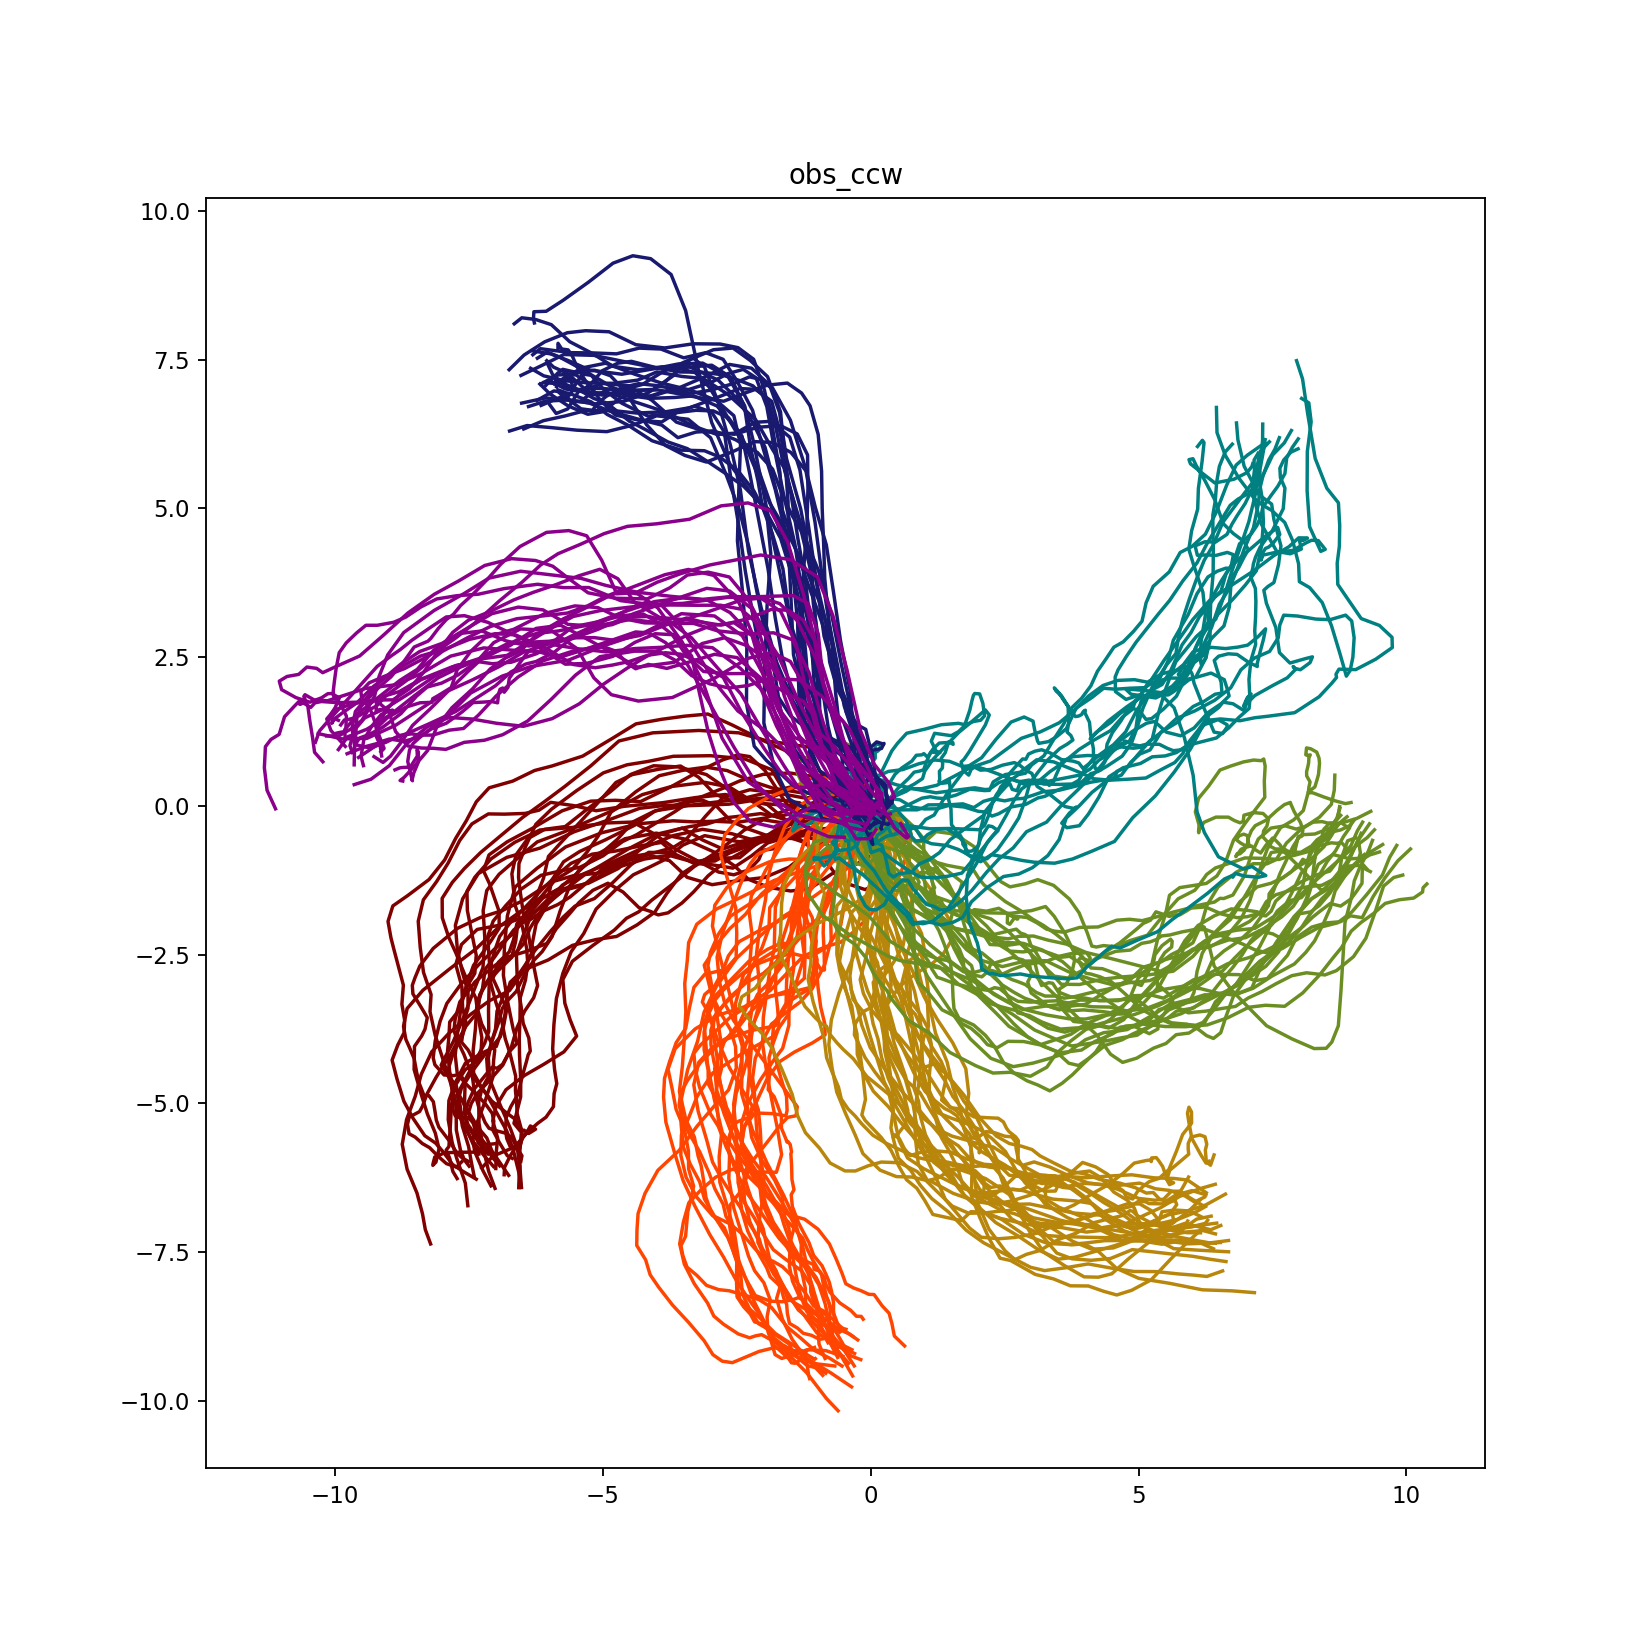

<IPython.core.display.Javascript object>


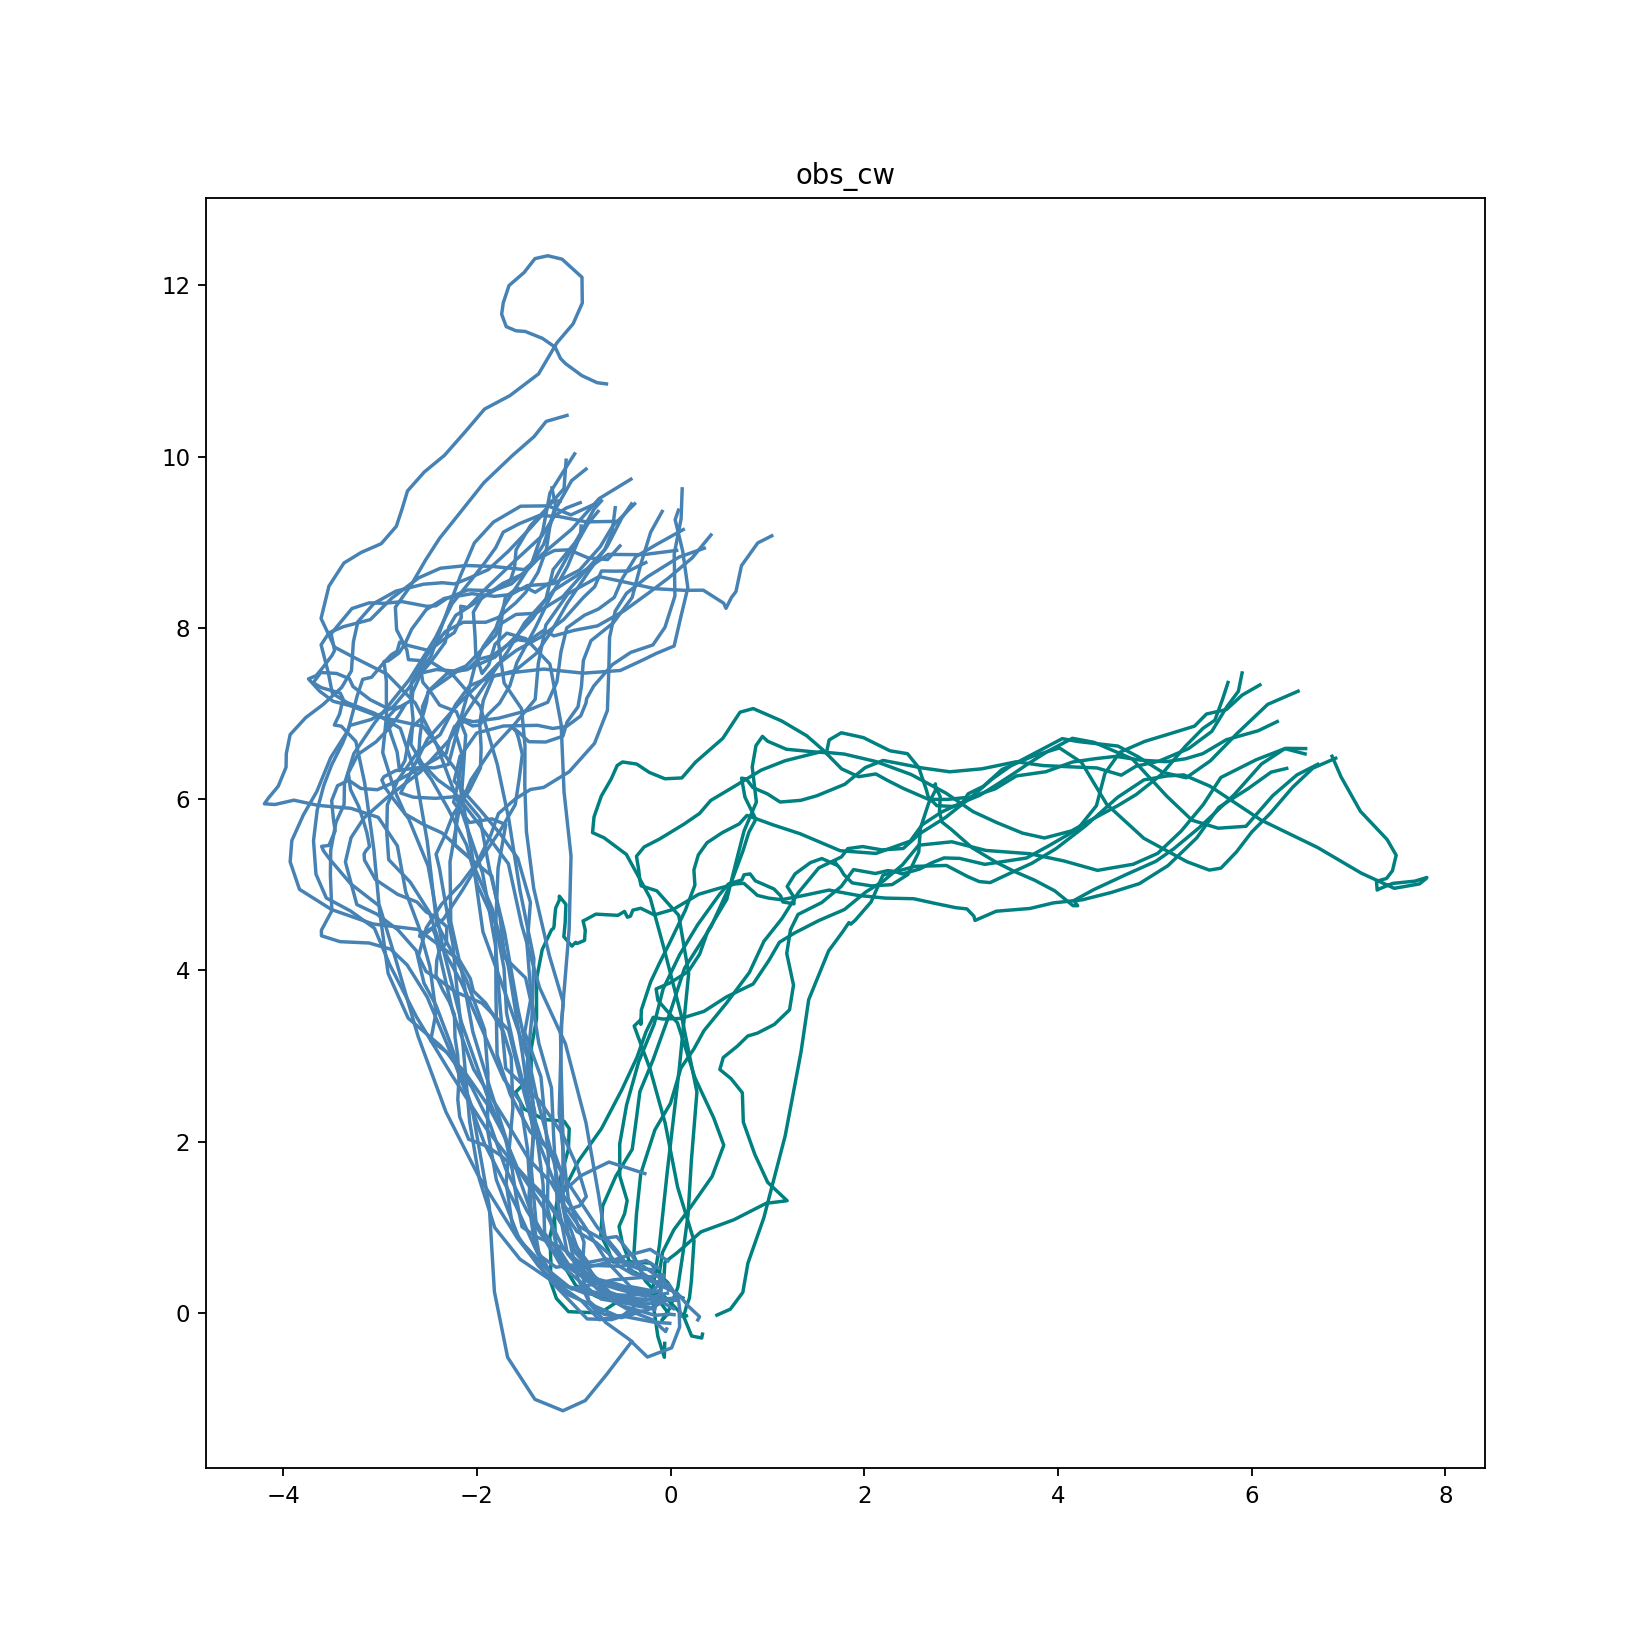

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)
                

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


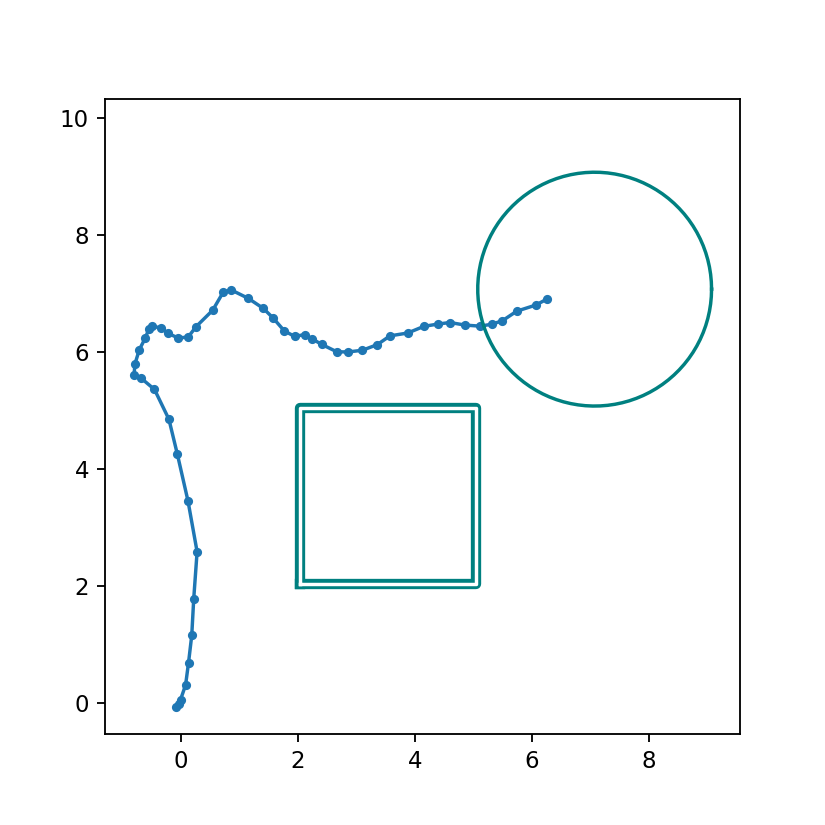

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [6]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

In [10]:
#LOAD:
a = 'grom'
d = str(0)
save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_init_fp_decoder_null_noisy.pkl')

with open(save_path, 'rb') as f: 
    r = pickle.load(f)
for (k,v) in r.items():
    exec(k+'=v')

save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'analysis_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl')
with open(save_path, 'rb') as f: 
    r2 = pickle.load(f)
for (k,v) in r2.items():
    exec(k+'=v')


In [26]:
#Dynamics models: 
a = 'grom'
d = str(0)
save_home = r'D:\DATA\bmi_co_obs_backup'
load_dir = os.path.join(save_home, a, str(d))

dm_list = ['full', 'decoder_null'] #dynamics, decoder_null dynamics
num_trials = 20 #number of trials simulated with lqr
# dm_files = {dm_list[0]:'lqr_sim_'+str(num_trials)+'trials.pkl',\
#             dm_list[1]:'lqr_sim_'+str(num_trials)+'trials_decoder_null_dyn.pkl'}

# dm_files = {dm_list[0]:'lqr_sim_Q2_full.pkl',\
#             dm_list[1]:'lqr_sim_Q2_decoder_null.pkl'}


dm_files = {dm_list[0]:'lqr_init_fp_full_noisy.pkl',\
            dm_list[1]:'lqr_init_fp_decoder_null_noisy.pkl'}

sim_dm_paths = {}
for dm in dm_list:
    sim_dm_paths[dm] = os.path.join(load_dir, dm_files[dm])
lqr_dm, df_pool = analyze_lqr.pool_lqr_sim_across_dm(dm_list, sim_dm_paths)

In [12]:
r.keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

In [11]:
r2.keys()

['p_sig_match',
 'task_rot_list',
 'num_neurons',
 'num_targets',
 'num_shuffle',
 'model_cm',
 'num_mag_bins_analyze',
 'r_u',
 'num_angle_bins',
 'Kn',
 'model_diff',
 'norm_u_df_n',
 'min_obs',
 'shuffle_bool',
 'r_n',
 'm_list',
 'n_list',
 'c_list']

In [14]:
df_lqr_n.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,u_p_angle,u_v_mag,u_v_angle,u_v_mag_bin,u_v_angle_bin,p_angle_ctr_t,v_angle_ctr_t,u_p_angle_ctr_t,u_v_angle_ctr_t,u_v_angle_ctr_bin
0,1.328601,0.496140,0.004279,-0.003336,1.202276,2.318799,1.388266,0.256369,-0.072159,0.081946,...,1.638770,8.561128e-15,1.655690,0.0,5.0,0.000000,0.000000,-4.644415,-4.627495,1.655690
1,1.649806,0.829527,0.752275,0.188004,1.613684,2.270020,1.021909,0.219886,-0.403178,0.372023,...,-2.374501,1.149972e+00,-2.374501,1.0,0.0,-0.581557,-0.581557,-2.374501,-2.374501,-2.374501
2,1.124026,0.880530,0.892030,0.243215,1.187094,2.570464,1.294524,0.152712,-0.812758,0.359845,...,-2.025126,1.425180e+00,-2.025126,1.0,0.0,-1.876363,-2.095460,-2.025126,-2.025126,-2.025126
3,1.439230,-0.268959,0.558292,-0.130732,1.176517,2.831184,1.347834,0.151351,-0.124002,0.587082,...,-2.582004,1.301340e+00,-2.582004,1.0,0.0,-1.928857,-1.940694,-2.582004,-2.582004,-2.582004
4,1.180915,0.203647,-0.171161,0.509937,1.467431,2.638515,1.602753,0.389464,-0.490388,0.385824,...,-2.519214,7.689903e-01,-2.519214,0.0,0.0,-2.030434,-2.206870,-2.519214,-2.519214,-2.519214


In [15]:
m_list

[(0, 0),
 (0, 1.1),
 (0, 1.2),
 (1, 0),
 (1, 1.1),
 (1, 1.2),
 (2, 0),
 (2, 1.1),
 (2, 1.2),
 (3, 0),
 (3, 1.1),
 (3, 1.2),
 (4, 0),
 (4, 1.1),
 (4, 1.2),
 (5, 0),
 (5, 1.1),
 (5, 1.2),
 (6, 0),
 (6, 1.1),
 (6, 1.2),
 (7, 0),
 (7, 1.1),
 (7, 1.2)]

In [19]:
model = ('decoder_null', 'n_o')

In [21]:
for mv in [m_list[0]]:
    for c in [c_list[0]]:
        print(c,mv)
        cm_sel = model_cm[model,c,mv,'sel']
        cm_idx = df_lqr_n[cm_sel].index.values
        pool_idx = model_cm[model,c,mv,'pool_match_idx']
        
        print(cm_idx)
        print(pool_idx)
        

((0, 0), (0, 0))
[]
<xarray.DataArray 'observation' (observation: 171)>
array([ 76599, 142529,  77187,  76793,  76939, 101709,  77093, 123823,  76575,
        76723,  92544,  76823, 129907,  77084,  76528,  77174,  86321,  77039,
        76729,  92465,  76735, 114307,  77136, 108223, 142107,  76805,  86400,
       145778,  77012, 145855,  85820, 124018,  77170,  76943,  76949,  77107,
        76652,  76485,  77171, 142433,  77016,  76641,  86214,  76486,  82872,
       105064, 108106,  76655,  77108,  76441,  76901, 135990, 107677,  92115,
        76535,  77004,  77162,  76585,  77160,  76885,  77120, 142385,  76720,
        98357,  86184,  76897,  76876,  77199,  76770,  77045,  76910,  76670,
        76692,  86571,  76620,  83457,  77009,  85841,  76893,  86243,  76896,
        77112,  86517,  76606,  89581,  76513,  76629,  77003,  76685,  76475,
       142204,  85940, 114658,  76638,  89542, 133181,  76580,  77144,  76871,
       145700,  82794, 104557,  76825,  76726,  77075,  767

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [23]:
df_lqr_n.shape

(74880, 118)

In [22]:
cm_sel

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
149730    False
149731    False
149732    False
149733    False
149734    False
149735    False
149736    False
149737    False
149738    False
149739    False
149740    False
149741    False
149742    False
149743    False
149744    False
149745    False
149746    False
149747    False
149748    False
149749    False
149750    False
149751    False
149752    False
149753    False
149754    False
149755    False
149756    False
149757    False
149758    False
149759    False
Length: 149760, dtype: b